In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import biosppy.signals.ecg as bio
import numpy as np

In [3]:
ECG_records = pd.read_csv('../data/ECG_records.csv',sep = ',')

In [4]:
ECG_records

,Unnamed: 0,Classification,1 p,2 p,3 p,4 p,5 p,6 p,7 p,8 p,...,3591 p,3592 p,3593 p,3594 p,3595 p,3596 p,3597 p,3598 p,3599 p,3600 p
0,0,0,953,951,949,948,950,950,951,948,...,942,938,938,941,944,943,943,940,943,944
1,1,0,915,927,934,936,935,938,938,936,...,965,965,964,965,966,966,966,965,963,962
2,2,0,989,984,981,981,983,987,984,982,...,946,947,946,952,951,952,949,949,949,952
3,3,0,957,961,961,960,960,961,964,968,...,1189,1128,1042,967,928,925,936,948,953,952
4,4,0,942,943,943,944,948,954,955,954,...,987,987,988,991,989,988,988,986,986,987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,16,1233,1153,1064,993,961,954,950,946,...,984,980,980,979,985,983,981,980,978,981
996,996,16,1192,1248,1301,1334,1328,1277,1194,1099,...,974,1002,1042,1092,1152,1203,1249,1288,1312,1294
997,997,16,1285,1252,1183,1101,1020,964,942,938,...,1005,1000,1002,1006,1017,1030,1040,1041,1032,1030
998,998,16,979,983,981,978,976,978,982,980,...,928,934,949,971,1007,1053,1115,1174,1227,1269


In [5]:
Classification = ECG_records['Classification']
ECG_records.drop(['Classification','Unnamed: 0'],axis='columns', inplace= True )

Функция фильтрации сигнала

In [6]:
def Filtsignal(data):
    return bio.ecg(data,360,show=False)[1]

Функция возвращает локализацию R-пиков

In [7]:
def Rpeaksloc(data):
    return bio.ecg(data,360,show=False)[2]

Фукнция возвращает амплитуду R-пиков.

In [8]:
def Rpeaksamp(data):
    bioecg = bio.ecg(data,360,show=False)
    amplitude = []
    for i in bioecg[2]:
        amplitude.append(bioecg[1][i])
    return amplitude

Функция поиска Q и S пиков, возвращает их индексы и амплитуды

In [9]:
def localization_of_Q_and_S_peaks(localization_of_R_pearks, filtred_signal):
    global index_min
    spisok_poiska = []
    spisok_Q_peaks = []
    spisok_S_peaks = []
    for j in localization_of_R_pearks:
        for i in range(j-50,j):
            spisok_poiska.append(filtred_signal[i])
        min = spisok_poiska[0]
        for k in range(len(spisok_poiska)):
            if spisok_poiska[k] < min:
                min = spisok_poiska[k]
                index_min = k
        spisok_Q_peaks.append(min)
        spisok_Q_peaks.append(j - 50 + index_min)
        spisok_poiska = []
        for i in range(j,j+50):
            spisok_poiska.append(filtred_signal[i])
        min = spisok_poiska[0]
        for k in range(len(spisok_poiska)):
            if spisok_poiska[k] < min:
                min = spisok_poiska[k]
                index_min = k
        spisok_S_peaks.append(min)
        spisok_S_peaks.append(j + index_min)
        spisok_poiska = []
    values_of_Q_peaks = []
    values_of_S_peaks = []
    Qindexes = []
    Sindexes = []
    for i in range(len(spisok_Q_peaks)):
        if i % 2 == 0:
            values_of_Q_peaks.append(spisok_Q_peaks[i])
            values_of_S_peaks.append(spisok_S_peaks[i])
        else:
            Qindexes.append(spisok_Q_peaks[i])
            Sindexes.append(spisok_S_peaks[i])
    Result = []
    Result.append(Qindexes)
    Result.append(values_of_Q_peaks)
    Result.append(Sindexes)
    Result.append(values_of_S_peaks)
    return Result #возвращает вложенный список: индексы значения амплитуд Q и S пиков

Среднее расстояние между R-пиками

In [10]:
def Rm(Rindexes):
    Rdistance = []
    for i in range(len(Rindexes)-1):
        Rdistance.append(Rindexes[i+1] - Rindexes[i])
    mean = np.array(Rdistance).mean()
    return mean

Функиция возвращает расстояние между пиками

In [11]:
def R_Rpeaks(Rindexes):
    Rdistance = []
    for i in range(len(Rindexes)-1):
        Rdistance.append(Rindexes[i+1] - Rindexes[i])
    return Rdistance

функция определения ЧСС в минуту: R-peaks * 6 (т.к. измерение происходит за 10 секунд)

In [12]:
def HearRate(R_peaks):
   return len(R_peaks) * 6

Средняя длительность QRS - комплекса

In [13]:
def QRSduration(Qind,Sind):
    duration = []
    for i in range(len(Qind)):
        duration.append(Sind[i]-Qind[i])
    mean = np.array(duration).mean()
    return mean

Длительности QRS - комплекса

In [14]:
def QRS(Qind,Sind):
    duration = []
    for i in range(len(Qind)):
        duration.append(Sind[i]-Qind[i])
    return np.array(duration)

Средняя R - амплитуда

In [15]:
def RampMean(Ramplitude):
    mean = np.array(Ramplitude).mean()
    return mean

Средняя Q - амплитуда

In [16]:
def QampMean(Qamplitude):
    mean = np.array(Qamplitude).mean()
    return mean

Средняя S - амплитуда

In [17]:
def SampMean(Samplitude):
    mean = np.array(Samplitude).mean()
    return mean

5 функций, каждая ищет наличие 1,2,3-х стандартных отклонений от амплитуд R,Q,S пиков, Длительности,QRS - комплекса, и расстояния между R-R пиками(нужно для проверки наличия аритмии)

In [18]:
#Ramp,Qamp,Samp,Rdlit,QRSdur,RampMean,QampMean,SampMean,RdlitMean,QRSdurMean
def R_otklonenie(Ramp,RampMean):
    eee = []
    std3 = 0
    std2 = 0
    std1 = 0
    for i in Ramp:
        if abs(RampMean - i) > 3 * np.std(Ramp):
            std3 = std3 + 1
    else:
        if abs(RampMean - i) > 2 * np.std(Ramp):
            std2 = std2 + 1
        else:
            if abs(RampMean - i) > np.std(Ramp):
                std1 = std1 + 1
    eee.append(std1)
    eee.append(std2)
    eee.append(std3)
    return eee
def Q_otklonenie(Qamp,QampMean):
    eee = []
    std1 = 0
    std2 = 0
    std3 = 0
    for i in Qamp:
        if abs(QampMean - i) > 3 * np.std(Qamp):
            std3 = std3 + 1
    else:
        if abs(QampMean - i) > 2 * np.std(Qamp):
            std2 = std2 + 1
        else:
            if abs(QampMean - i) > np.std(Qamp):
                std1 = std1 + 1
    eee.append(std1)
    eee.append(std2)
    eee.append(std3)
    return eee
def S_otklonenie(Samp,SampMean):
    eee = []
    std1 = 0
    std2 = 0
    std3 = 0
    for i in Samp:
        if abs(SampMean - i) > 3 * np.std(Samp):
            std3 = std3 + 1
    else:
        if abs(SampMean - i) > 2 * np.std(Samp):
            std2 = std2 + 1
        else:
            if abs(SampMean - i) > np.std(Samp):
                std1 = std1 + 1
    eee.append(std1)
    eee.append(std2)
    eee.append(std3)
    return eee
def Rdlit_otklonenie(Rdlit,RdlitMean):
    eee = []
    std1 = 0
    std2 = 0
    std3 = 0
    for i in Rdlit:
        if abs(RdlitMean - i) > 3 * np.std(Rdlit):
            std3 = std3 + 1
    else:
        if abs(RdlitMean - i) > 2 * np.std(Rdlit):
            std2 = std2 + 1
        else:
            if abs(RdlitMean - i) > np.std(Rdlit):
                std1 = std1 + 1
    eee.append(std1)
    eee.append(std2)
    eee.append(std3)
    return eee
def QRSdur_otklonenie(QRSdur,QRSdurMean):
    eee = []
    std1 = 0
    std2 = 0
    std3 = 0
    for i in QRSdur:
        if abs(QRSdurMean - i) > 3 * np.std(QRSdur):
            std3 = std3 + 1
    else:
        if abs(QRSdurMean - i) > 2 * np.std(QRSdur):
            std2 = std2 + 1
        else:
            if abs(QRSdurMean - i) > np.std(QRSdur):
                std1 = std1 + 1
    eee.append(std1)
    eee.append(std2)
    eee.append(std3)
    return eee

In [18]:
# Создаём массивы, чтобы потом собрать DataFrame с обработанными данными, для обучения(понимаю, что быдлокод, но я по другому не смог)
Rmean = [] # среднее расстояние между пиками
Hrate = [] # ЧСС в минуту
QRSsrednee = [] # средняя длительность QRS - комплекса
Ramplmean = [] # средняя амплитуда R-пика
Qamplmean = [] # средняя амплитуда Q - пика
Samplmean = [] # средняя амплитуда S - пика
Rotklonenie = [] # хранит наличие 1,2,3 стандартных отклонений от Rmean
Ramp_otklonenie = [] # хранит наличие 1,2,3 стандартных отклонений от средней амплитуды
Qamp_otklonenie = []# хранит наличие 1,2,3 стандартных отклонений от средней амплитуды
Samp_otklonenie = [] # хранит наличие 1,2,3 стандартных отклонений от средней амплитуды
QRS_otklonenie = [] # хранит наличие 1,2,3 стандартных отклонений от средней длительности QRS - комплекса
# сбор всех функций в одну
def MLdataset(ECG):
    Result = []
    Filtred_signal = Filtsignal(ECG)
    R_localization = Rpeaksloc(ECG)
    R_amplitude =  Rpeaksamp(ECG)
    QSpeaks = localization_of_Q_and_S_peaks(R_localization,Filtred_signal)
    Result.append(Rm(R_localization)) # запись среднего расстояния между пиками
    Result.append(HearRate(R_localization)) # запись ЧСС
    Result.append(QRSduration(QSpeaks[0],QSpeaks[2])) # запись средней длительности QRS - комплекса
    Result.append(RampMean(R_amplitude))# запись средней амплитуды R - пика
    Result.append(QampMean(QSpeaks[1])) 
    Result.append(SampMean(QSpeaks[3]))
    Result.append(Rdlit_otklonenie(R_Rpeaks(R_localization),Rm(R_localization))) # запись отклонений от Rmean
    Result.append(R_otklonenie(R_amplitude,RampMean(R_amplitude))) # запись отклонений по R-амплитуде
    Result.append(Q_otklonenie(QSpeaks[1],QampMean(QSpeaks[1])))# запись отклонений по Q-амплитуде
    Result.append(S_otklonenie(QSpeaks[3],SampMean(QSpeaks[3])))# запись отклонений по S-амплитуде
    Result.append(QRSdur_otklonenie(QRS(QSpeaks[0],QSpeaks[2]),QRSduration(QSpeaks[0],QSpeaks[2]))) # запись отклонений по QRS
    return Result

for i in range(1000):
    MLdat = MLdataset(ECG_records.loc[i])
    Rmean.append(MLdat[0])
    Hrate.append(MLdat[1])
    QRSsrednee.append(MLdat[2])
    Ramplmean.append(MLdat[3])
    Qamplmean.append(MLdat[4])
    Samplmean.append(MLdat[5])
    Rotklonenie.append(MLdat[6])
    Ramp_otklonenie.append(MLdat[7])
    Qamp_otklonenie.append(MLdat[8])
    Samp_otklonenie.append(MLdat[9])
    QRS_otklonenie.append(MLdat[10])


In [20]:
N = [i/360 for i in range(3600)]

In [22]:
QSpeaks = np.array(localization_of_Q_and_S_peaks(Rpeaksloc(ECG_records.loc[0]),Filtsignal(ECG_records.loc[0])))


In [48]:
len(QSpeaks[0])

12

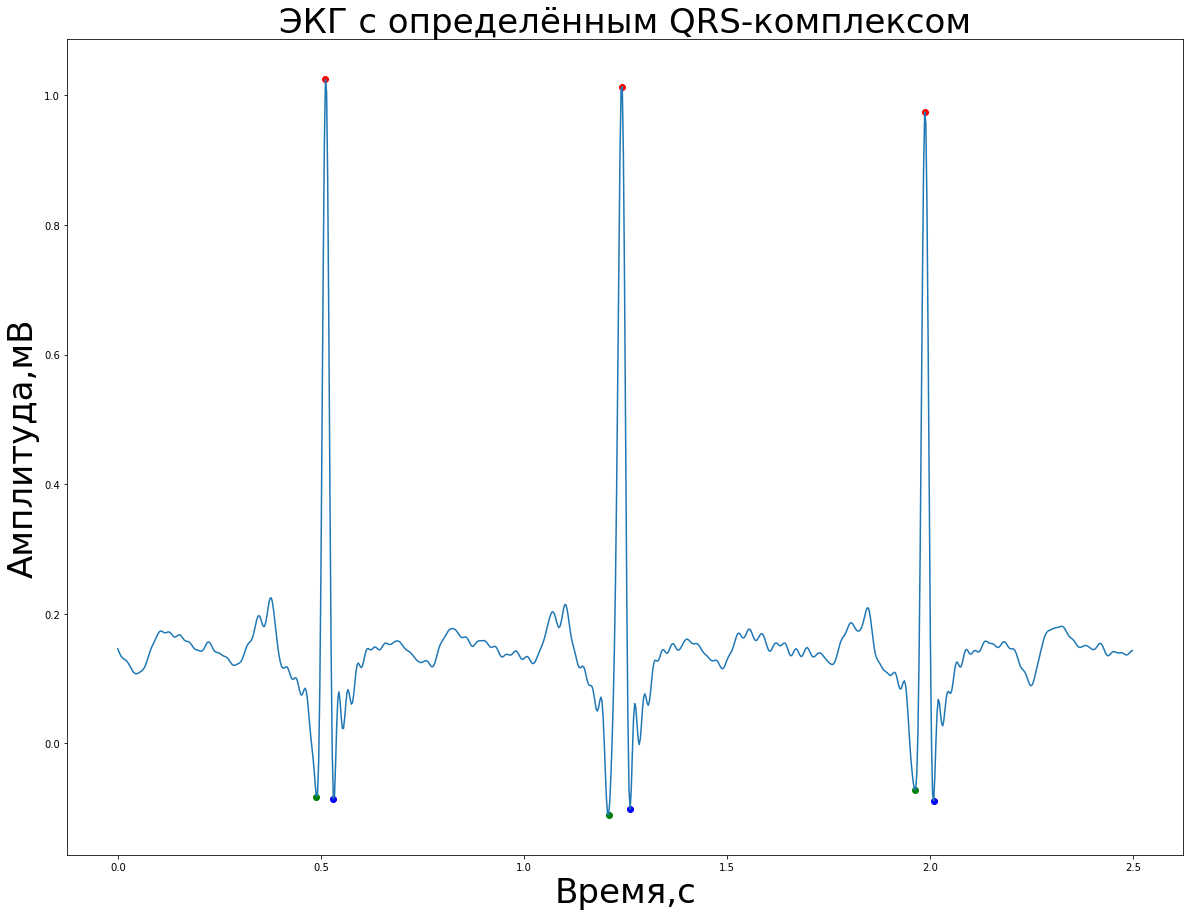

In [23]:
plt.figure(figsize=(20,15))
plt.plot(N[:900],Filtsignal(ECG_records.loc[0])[:900]/275)
plt.scatter(np.array(Rpeaksloc(ECG_records.loc[0]))[:3]/360,np.array(Rpeaksamp(ECG_records.loc[0]))[:3]/275,c = 'r')
plt.scatter(QSpeaks[0][:3]/360,QSpeaks[1][:3]/275,c='g')
plt.scatter(QSpeaks[2][:3]/360,QSpeaks[3][:3]/275,c='b')
plt.title('ЭКГ с определённым QRS-комплексом',fontsize = 34)
plt.xlabel('Время,с',fontsize=34)
plt.ylabel('Амплитуда,мВ',fontsize=34)
plt.show()

In [235]:
Col1 = ['ЧСС','Среднее R-R расстояние','Средняя длительность QRS','Средняя R - амплитуда',
      'Средняя Q-амплитуда', "Средняя S-амплитуда"]

In [236]:
Col2 = ['от среднего R-R расстояния','от средней R-амплитуды','от средней Q-амплитуды',"от средней S-амплитуды","от средней длительности QRS"]

In [237]:
Col = []
for j in range(len(Col2)):
    for i in range(3):
        Col.append('{0} std {1}'.format((i+1),Col2[j]))

In [238]:
Col3 = Col1 + Col

In [239]:
df = pd.DataFrame(columns = Col3)    

In [240]:
df

,ЧСС,Среднее R-R расстояние,Средняя длительность QRS,Средняя R - амплитуда,Средняя Q-амплитуда,Средняя S-амплитуда,1 std от среднего R-R расстояния,2 std от среднего R-R расстояния,3 std от среднего R-R расстояния,1 std от средней R-амплитуды,...,3 std от средней R-амплитуды,1 std от средней Q-амплитуды,2 std от средней Q-амплитуды,3 std от средней Q-амплитуды,1 std от средней S-амплитуды,2 std от средней S-амплитуды,3 std от средней S-амплитуды,1 std от средней длительности QRS,2 std от средней длительности QRS,3 std от средней длительности QRS


In [241]:
df['ЧСС'] = Hrate
df['Среднее R-R расстояние'] = Rmean
df['Средняя длительность QRS'] = QRSsrednee
df['Средняя R - амплитуда'] = Ramplmean
df['Средняя Q-амплитуда'] = Qamplmean
df['Средняя S-амплитуда'] = Samplmean
df['Диагноз'] = Classification

In [242]:
df

,ЧСС,Среднее R-R расстояние,Средняя длительность QRS,Средняя R - амплитуда,Средняя Q-амплитуда,Средняя S-амплитуда,1 std от среднего R-R расстояния,2 std от среднего R-R расстояния,3 std от среднего R-R расстояния,1 std от средней R-амплитуды,...,1 std от средней Q-амплитуды,2 std от средней Q-амплитуды,3 std от средней Q-амплитуды,1 std от средней S-амплитуды,2 std от средней S-амплитуды,3 std от средней S-амплитуды,1 std от средней длительности QRS,2 std от средней длительности QRS,3 std от средней длительности QRS,Диагноз
0,72,275.818182,17.250000,270.778556,-22.899978,-24.106559,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,72,288.000000,17.250000,264.691394,-23.189547,-22.424971,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,78,261.916667,16.923077,266.893787,-20.291446,-27.073399,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,78,269.666667,16.769231,274.302185,-20.009461,-28.933266,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,72,275.181818,18.166667,265.966190,-23.319300,-28.145374,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,66,276.800000,26.181818,297.248628,-13.384910,-29.517939,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
996,60,321.222222,24.200000,304.735312,-15.166034,-25.909795,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
997,72,280.454545,27.500000,279.209689,-11.550450,-29.856714,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16
998,66,327.900000,23.181818,302.267174,-14.700896,-25.017912,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16


In [243]:
df.columns

Index(['ЧСС', 'Среднее R-R расстояние', 'Средняя длительность QRS',
       'Средняя R - амплитуда', 'Средняя Q-амплитуда', 'Средняя S-амплитуда',
       '1 std от среднего R-R расстояния', '2 std от среднего R-R расстояния',
       '3 std от среднего R-R расстояния', '1 std от средней R-амплитуды',
       '2 std от средней R-амплитуды', '3 std от средней R-амплитуды',
       '1 std от средней Q-амплитуды', '2 std от средней Q-амплитуды',
       '3 std от средней Q-амплитуды', '1 std от средней S-амплитуды',
       '2 std от средней S-амплитуды', '3 std от средней S-амплитуды',
       '1 std от средней длительности QRS',
       '2 std от средней длительности QRS',
       '3 std от средней длительности QRS', 'Диагноз'],
      dtype='object')

In [244]:
for i in range(1000):
    for j in range(3):
        df.loc[i,'%i std от среднего R-R расстояния'%(j+1)] = Rotklonenie[i][j]

In [245]:
for i in range(1000):
    for j in range(3):
        df.loc[i,"%i std от средней R-амплитуды"%(j+1)] = Ramp_otklonenie[i][j]

In [246]:
for i in range(1000):
    for j in range(3):
        df.loc[i,"%i std от средней Q-амплитуды"%(j+1)] = Qamp_otklonenie[i][j]

In [247]:
for i in range(1000):
    for j in range(3):
        df.loc[i,"%i std от средней S-амплитуды"%(j+1)] = Samp_otklonenie[i][j]

In [248]:
for i in range(1000):
    for j in range(3):
        df.loc[i,"%i std от средней длительности QRS"%(j+1)] = QRS_otklonenie[i][j]

In [249]:
df

,ЧСС,Среднее R-R расстояние,Средняя длительность QRS,Средняя R - амплитуда,Средняя Q-амплитуда,Средняя S-амплитуда,1 std от среднего R-R расстояния,2 std от среднего R-R расстояния,3 std от среднего R-R расстояния,1 std от средней R-амплитуды,...,1 std от средней Q-амплитуды,2 std от средней Q-амплитуды,3 std от средней Q-амплитуды,1 std от средней S-амплитуды,2 std от средней S-амплитуды,3 std от средней S-амплитуды,1 std от средней длительности QRS,2 std от средней длительности QRS,3 std от средней длительности QRS,Диагноз
0,72,275.818182,17.250000,270.778556,-22.899978,-24.106559,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,72,288.000000,17.250000,264.691394,-23.189547,-22.424971,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,78,261.916667,16.923077,266.893787,-20.291446,-27.073399,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,78,269.666667,16.769231,274.302185,-20.009461,-28.933266,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,72,275.181818,18.166667,265.966190,-23.319300,-28.145374,0,0,0,1,...,1,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,66,276.800000,26.181818,297.248628,-13.384910,-29.517939,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
996,60,321.222222,24.200000,304.735312,-15.166034,-25.909795,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16
997,72,280.454545,27.500000,279.209689,-11.550450,-29.856714,0,1,0,0,...,0,0,0,0,0,0,0,0,0,16
998,66,327.900000,23.181818,302.267174,-14.700896,-25.017912,1,0,0,0,...,0,0,0,0,0,0,0,0,1,16


In [250]:
df.to_csv('данные для обучения.csv',sep = ',')

In [67]:
from numpy import array, arange, abs as np_abs
from numpy.fft import rfft, rfftfreq,fft,fftfreq
from numpy.random import uniform
from sklearn.utils import shuffle

In [64]:
FD = 360 # частота дискретизации, отсчётов в секунду
N = 3600 # длина входного массива, 10 секунд при такой частоте дискретизации
def FFT(signal):
    Result = []
    voltaj = Filtsignal(signal)/275
    spectrum = fft(voltaj)
    spectrum = np_abs(spectrum)/N
    freq = fftfreq(N,1./FD)
    Result.append(spectrum)
    Result.append(freq)
    return Result

In [65]:
def SpectAnalis(spectr,freq):
    chastoti = []
    result = []
    indexes = []
    sort = np.sort(spectr)
    spectr_copy = list(spectr)
    result.append(sort[len(sort)-10:len(sort)])
    for i in sort[len(sort)-10:len(sort)]:
        indexes.append(spectr_copy.index(i))
    for i in indexes:
        chastoti.append(freq[i])
    result.append(chastoti)
    return result

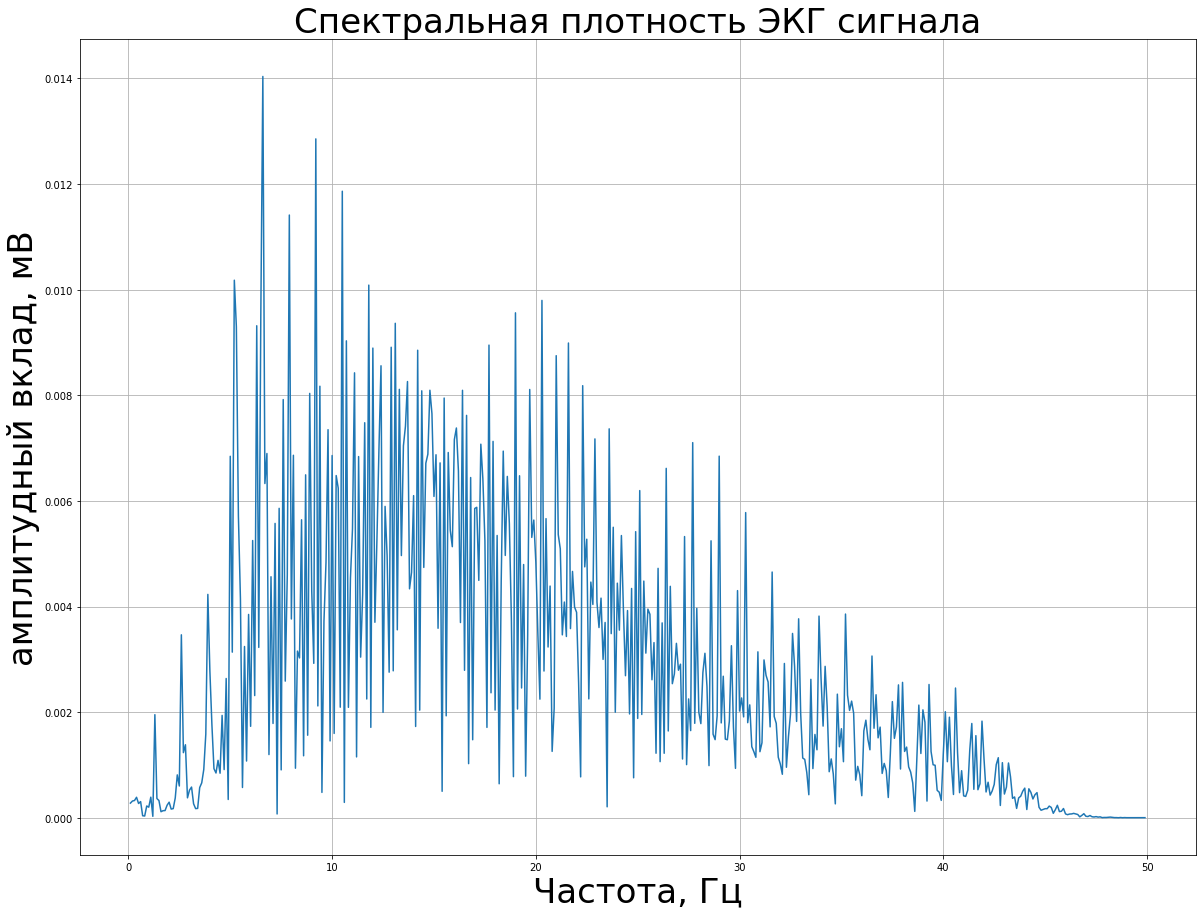

In [77]:
plt.figure(figsize=(20,15))
plt.plot(FFT(ECG_records.loc[0])[1][1:500], FFT(ECG_records.loc[0])[0][1:500])
# rfftfreq сделает всю работу по преобразованию номеров элементов массива в герцы
# нас интересует только спектр амплитуд, поэтому используем abs из numpy (действует на массивы поэлементно)
# делим на число элементов, чтобы амплитуды были в милливольтах, а не в суммах Фурье. Проверить просто — постоянные составляющие должны совпадать в сгенерированном сигнале и в спектре
plt.xlabel('Частота, Гц',fontsize = 34)
plt.ylabel('амплитудный вклад, мВ',fontsize = 34)
plt.title('Спектральная плотность ЭКГ сигнала',fontsize = 34)
plt.grid(True)
plt.show()